In [4]:
import pickle
import numpy as np
import pandas as pd
import math
import sys,os
#from sklearn import metrics
#from sklearn.cluster import KMeans
#from sklearn.preprocessing import StandardScaler, normalize
#from scipy.spatial.distance import cdist
#import matplotlib.pyplot as plt
#import seaborn as sns

In [10]:
sys.path.append(os.path.abspath(os.path.join('../utils')))
from cleaner import *
from helper import *
from plot import *
from outlier_handler import OutlierHandler

In [11]:
df = pd.read_csv("../data/clean_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146887 entries, 0 to 146886
Data columns (total 48 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Unnamed: 0                      146887 non-null  int64  
 1   Bearer Id                       146887 non-null  int64  
 2   Start                           146887 non-null  object 
 3   Start ms                        146887 non-null  float64
 4   End                             146887 non-null  object 
 5   End ms                          146887 non-null  float64
 6   Dur. (ms)                       146887 non-null  float64
 7   IMSI                            146887 non-null  int64  
 8   MSISDN/Number                   146887 non-null  int64  
 9   IMEI                            146887 non-null  int64  
 10  Last Location Name              146887 non-null  object 
 11  Avg RTT DL (ms)                 146887 non-null  float64
 12  Avg RTT UL (ms) 

In [12]:
convert_to_datetime(df, ['Start', 'End'])

In [13]:
string_columns = df.select_dtypes(include='object').columns.tolist()
string_columns

['Last Location Name', 'Handset Manufacturer', 'Handset Type']

In [15]:
convert_to_string(df, string_columns)
df.dtypes

Unnamed: 0                                 int64
Bearer Id                                  int64
Start                             datetime64[ns]
Start ms                                 float64
End                               datetime64[ns]
End ms                                   float64
Dur. (ms)                                float64
IMSI                                       int64
MSISDN/Number                              int64
IMEI                                       int64
Last Location Name                string[python]
Avg RTT DL (ms)                          float64
Avg RTT UL (ms)                          float64
Avg Bearer TP DL (kbps)                  float64
Avg Bearer TP UL (kbps)                  float64
TCP DL Retrans. Vol (Bytes)              float64
TCP UL Retrans. Vol (Bytes)              float64
DL TP < 50 Kbps (%)                      float64
50 Kbps < DL TP < 250 Kbps (%)           float64
250 Kbps < DL TP < 1 Mbps (%)            float64
DL TP > 1 Mbps (%)  

In [26]:
df['Total Data Volume (Bytes)'] = df['Total UL (Bytes)'] + df['Total DL (Bytes)']
user_engage = df[['MSISDN/Number', 'Bearer Id', 'Dur. (ms)', 'Total Data Volume (Bytes)']]

# aggregating user engagement metrics per user
user_engage = user_engage.groupby(
    'MSISDN/Number').agg({'Bearer Id': 'count', 'Dur. (ms)': 'sum', 'Total Data Volume (Bytes)': 'sum'})
user_engage = user_engage.rename(
    columns={'Bearer Id': 'xdr Sessions'})
user_engage.head(10)

,xdr Sessions,Dur. (ms),Total Data Volume (Bytes)
MSISDN/Number,,,
33601001722,1,116720.00,8.786906e+08
33601001754,1,181230.00,1.568596e+08
33601002511,1,134969.00,5.959665e+08
33601007832,1,49878.00,4.223207e+08
33601008617,2,37104.00,1.457411e+09
33601010682,2,253983.00,6.152172e+08
33601011634,2,128360.00,6.531412e+08
33601011959,1,86399.00,3.326604e+08
33601014694,2,400957.75,9.901322e+08


Top 10 customers per xdr Sessions

In [27]:
user_engage.nlargest(10, 'xdr Sessions')

,xdr Sessions,Dur. (ms),Total Data Volume (Bytes)
MSISDN/Number,,,
33626320676,18,4007341.50,7.971167e+09
33614892860,17,3900319.50,8.846226e+09
33625779332,17,4138392.00,8.499621e+09
33659725664,16,3492565.50,7.705863e+09
33675877202,15,3332218.50,7.891111e+09
33760536639,15,3396880.25,8.514774e+09
33667163239,13,3114208.00,5.618394e+09
33603127838,12,2855532.25,4.976195e+09
33604515716,12,2780120.50,5.487855e+09


Top 10 customers per Dur. (ms)

In [28]:
user_engage.nlargest(10, 'Dur. (ms)')

,xdr Sessions,Dur. (ms),Total Data Volume (Bytes)
MSISDN/Number,,,
33625779332,17,4138392.00,8.499621e+09
33626320676,18,4007341.50,7.971167e+09
33614892860,17,3900319.50,8.846226e+09
33659725664,16,3492565.50,7.705863e+09
33760536639,15,3396880.25,8.514774e+09
33675877202,15,3332218.50,7.891111e+09
33667163239,13,3114208.00,5.618394e+09
33603127838,12,2855532.25,4.976195e+09
33627080969,12,2782427.50,5.754731e+09


Top 10 customers per total data volumes (Bytes)

In [29]:
user_engage.nlargest(10, 'Total Data Volume (Bytes)')

,xdr Sessions,Dur. (ms),Total Data Volume (Bytes)
MSISDN/Number,,,
33614892860,17,3900319.50,8.846226e+09
33760536639,15,3396880.25,8.514774e+09
33625779332,17,4138392.00,8.499621e+09
33626320676,18,4007341.50,7.971167e+09
33675877202,15,3332218.50,7.891111e+09
33659725664,16,3492565.50,7.705863e+09
33666464084,11,2597081.75,7.308501e+09
33760413819,12,2676855.75,7.132371e+09
33664712899,11,2603565.25,6.872337e+09


## Total trafic of application per user

In [32]:
df['Social Media (Bytes)'] = df['Social Media UL (Bytes)'] + df['Social Media DL (Bytes)']
df['Google (Bytes)'] = df['Google UL (Bytes)'] + df['Google DL (Bytes)']
df['Email (Bytes)'] = df['Email UL (Bytes)'] + df['Email DL (Bytes)']
df['Youtube (Bytes)'] = df['Youtube UL (Bytes)'] + df['Youtube DL (Bytes)']
df['Netflix (Bytes)'] = df['Netflix UL (Bytes)'] + df['Netflix DL (Bytes)']
df['Gaming (Bytes)'] = df['Gaming UL (Bytes)'] + df['Gaming DL (Bytes)']
df['Other (Bytes)'] = df['Other UL (Bytes)'] + df['Other DL (Bytes)']

app_engage_per_user = df[['MSISDN/Number', 'Social Media (Bytes)', 'Google (Bytes)',
    'Email (Bytes)', 'Youtube (Bytes)', 'Netflix (Bytes)',
    'Gaming (Bytes)', 'Other (Bytes)']]

In [33]:

app_engage_per_user = app_engage_per_user.groupby(
    'MSISDN/Number').sum()
app_engage_per_user.head(10)

,Social Media (Bytes),Google (Bytes),Email (Bytes),Youtube (Bytes),Netflix (Bytes),Gaming (Bytes),Other (Bytes)
MSISDN/Number,,,,,,,
33601001722,2232135.0,4389005.0,1331362.0,21624548.0,27180981.0,8.124587e+08,3.865709e+08
33601001754,2660565.0,5334863.0,3307781.0,12432223.0,11221763.0,1.197501e+08,2.817101e+08
33601002511,3195623.0,3443126.0,3205380.0,21333570.0,19353900.0,5.388277e+08,5.016937e+08
33601007832,280294.0,9678493.0,2284670.0,6977321.0,1942092.0,3.911261e+08,3.527970e+07
33601008617,2912542.0,18499616.0,3305469.0,41533002.0,49201724.0,1.314798e+09,8.048045e+08
33601010682,3792912.0,15263134.0,7848596.0,34347122.0,30315501.0,5.116358e+08,4.923728e+08
33601011634,2769627.0,10196403.0,1358959.0,26431335.0,45812397.0,5.484611e+08,2.248887e+08
33601011959,1782692.0,12023614.0,2215563.0,18892740.0,15292840.0,2.823644e+08,1.782015e+08
33601014694,5288685.0,14134211.0,4599825.0,63443802.0,54216117.0,8.330880e+08,1.041883e+09


Top 10 most engaged users per application

Social Media

In [34]:
app_engage_per_user.nlargest(10, 'Social Media (Bytes)')

,Social Media (Bytes),Google (Bytes),Email (Bytes),Youtube (Bytes),Netflix (Bytes),Gaming (Bytes),Other (Bytes)
MSISDN/Number,,,,,,,
33626320676,43374779.0,152191852.0,42418782.0,374483047.0,328725740.0,6.887572e+09,8.167878e+09
33760536639,39783189.0,123223099.0,33693767.0,396289198.0,334643269.0,7.461045e+09,4.716134e+09
33659725664,35412358.0,116516345.0,35999792.0,257991088.0,399519079.0,6.725559e+09,6.317415e+09
33614892860,28294544.0,127973787.0,40788634.0,394370218.0,361401046.0,7.749432e+09,7.639264e+09
33625779332,27135500.0,142307915.0,40633966.0,452958769.0,356980607.0,7.326673e+09,6.354583e+09
33667163239,24247850.0,105032696.0,30335796.0,315231310.0,313939488.0,4.725622e+09,4.941519e+09
33603127838,23077825.0,86929016.0,26198895.0,284090139.0,260488421.0,4.191445e+09,6.326671e+09
33661594030,22434016.0,62883039.0,26749850.0,228681782.0,231656299.0,3.375999e+09,4.824162e+09
33659359429,21321646.0,91041018.0,25616916.0,220491966.0,230616798.0,4.016571e+09,4.571743e+09


Google

In [35]:
app_engage_per_user.nlargest(10, 'Google (Bytes)')

,Social Media (Bytes),Google (Bytes),Email (Bytes),Youtube (Bytes),Netflix (Bytes),Gaming (Bytes),Other (Bytes)
MSISDN/Number,,,,,,,
33626320676,43374779.0,152191852.0,42418782.0,374483047.0,328725740.0,6.887572e+09,8.167878e+09
33625779332,27135500.0,142307915.0,40633966.0,452958769.0,356980607.0,7.326673e+09,6.354583e+09
33614892860,28294544.0,127973787.0,40788634.0,394370218.0,361401046.0,7.749432e+09,7.639264e+09
33760536639,39783189.0,123223099.0,33693767.0,396289198.0,334643269.0,7.461045e+09,4.716134e+09
33659725664,35412358.0,116516345.0,35999792.0,257991088.0,399519079.0,6.725559e+09,6.317415e+09
33675877202,19222921.0,109860502.0,31514421.0,317410572.0,309093159.0,6.970568e+09,6.798515e+09
33667163239,24247850.0,105032696.0,30335796.0,315231310.0,313939488.0,4.725622e+09,4.941519e+09
33761268199,14496080.0,97089988.0,20753721.0,272789592.0,292091341.0,4.274099e+09,5.077779e+09
33659359429,21321646.0,91041018.0,25616916.0,220491966.0,230616798.0,4.016571e+09,4.571743e+09


Youtube

In [36]:
app_engage_per_user.nlargest(10, 'Youtube (Bytes)')

,Social Media (Bytes),Google (Bytes),Email (Bytes),Youtube (Bytes),Netflix (Bytes),Gaming (Bytes),Other (Bytes)
MSISDN/Number,,,,,,,
33625779332,27135500.0,142307915.0,40633966.0,452958769.0,356980607.0,7.326673e+09,6.354583e+09
33760536639,39783189.0,123223099.0,33693767.0,396289198.0,334643269.0,7.461045e+09,4.716134e+09
33614892860,28294544.0,127973787.0,40788634.0,394370218.0,361401046.0,7.749432e+09,7.639264e+09
33626320676,43374779.0,152191852.0,42418782.0,374483047.0,328725740.0,6.887572e+09,8.167878e+09
33675877202,19222921.0,109860502.0,31514421.0,317410572.0,309093159.0,6.970568e+09,6.798515e+09
33667163239,24247850.0,105032696.0,30335796.0,315231310.0,313939488.0,4.725622e+09,4.941519e+09
33627080969,17808911.0,87125921.0,23567219.0,308790774.0,267040897.0,4.972353e+09,5.117791e+09
33760413819,20777205.0,82738720.0,25576965.0,303169107.0,318347546.0,6.268620e+09,4.101645e+09
33698792269,15728161.0,79736125.0,29059042.0,302661958.0,268247480.0,5.753743e+09,4.689876e+09


Email

In [37]:
app_engage_per_user.nlargest(10, 'Email (Bytes)')

,Social Media (Bytes),Google (Bytes),Email (Bytes),Youtube (Bytes),Netflix (Bytes),Gaming (Bytes),Other (Bytes)
MSISDN/Number,,,,,,,
33626320676,43374779.0,152191852.0,42418782.0,374483047.0,328725740.0,6.887572e+09,8.167878e+09
33614892860,28294544.0,127973787.0,40788634.0,394370218.0,361401046.0,7.749432e+09,7.639264e+09
33625779332,27135500.0,142307915.0,40633966.0,452958769.0,356980607.0,7.326673e+09,6.354583e+09
33659725664,35412358.0,116516345.0,35999792.0,257991088.0,399519079.0,6.725559e+09,6.317415e+09
33760536639,39783189.0,123223099.0,33693767.0,396289198.0,334643269.0,7.461045e+09,4.716134e+09
33675877202,19222921.0,109860502.0,31514421.0,317410572.0,309093159.0,6.970568e+09,6.798515e+09
33665460546,10554843.0,63597426.0,30417885.0,232292532.0,197517914.0,4.781003e+09,2.973452e+09
33667163239,24247850.0,105032696.0,30335796.0,315231310.0,313939488.0,4.725622e+09,4.941519e+09
33698792269,15728161.0,79736125.0,29059042.0,302661958.0,268247480.0,5.753743e+09,4.689876e+09


Netflix

In [38]:
app_engage_per_user.nlargest(10, 'Netflix (Bytes)')

,Social Media (Bytes),Google (Bytes),Email (Bytes),Youtube (Bytes),Netflix (Bytes),Gaming (Bytes),Other (Bytes)
MSISDN/Number,,,,,,,
33659725664,35412358.0,116516345.0,35999792.0,257991088.0,399519079.0,6.725559e+09,6.317415e+09
33614892860,28294544.0,127973787.0,40788634.0,394370218.0,361401046.0,7.749432e+09,7.639264e+09
33625779332,27135500.0,142307915.0,40633966.0,452958769.0,356980607.0,7.326673e+09,6.354583e+09
33760536639,39783189.0,123223099.0,33693767.0,396289198.0,334643269.0,7.461045e+09,4.716134e+09
33626320676,43374779.0,152191852.0,42418782.0,374483047.0,328725740.0,6.887572e+09,8.167878e+09
33760413819,20777205.0,82738720.0,25576965.0,303169107.0,318347546.0,6.268620e+09,4.101645e+09
33667163239,24247850.0,105032696.0,30335796.0,315231310.0,313939488.0,4.725622e+09,4.941519e+09
33675877202,19222921.0,109860502.0,31514421.0,317410572.0,309093159.0,6.970568e+09,6.798515e+09
33761268199,14496080.0,97089988.0,20753721.0,272789592.0,292091341.0,4.274099e+09,5.077779e+09


Gaming

In [39]:
app_engage_per_user.nlargest(10, 'Gaming (Bytes)')

,Social Media (Bytes),Google (Bytes),Email (Bytes),Youtube (Bytes),Netflix (Bytes),Gaming (Bytes),Other (Bytes)
MSISDN/Number,,,,,,,
33614892860,28294544.0,127973787.0,40788634.0,394370218.0,361401046.0,7.749432e+09,7.639264e+09
33760536639,39783189.0,123223099.0,33693767.0,396289198.0,334643269.0,7.461045e+09,4.716134e+09
33625779332,27135500.0,142307915.0,40633966.0,452958769.0,356980607.0,7.326673e+09,6.354583e+09
33675877202,19222921.0,109860502.0,31514421.0,317410572.0,309093159.0,6.970568e+09,6.798515e+09
33626320676,43374779.0,152191852.0,42418782.0,374483047.0,328725740.0,6.887572e+09,8.167878e+09
33659725664,35412358.0,116516345.0,35999792.0,257991088.0,399519079.0,6.725559e+09,6.317415e+09
33666464084,18629986.0,89320737.0,25557139.0,227336012.0,214416926.0,6.646303e+09,4.349141e+09
33760413819,20777205.0,82738720.0,25576965.0,303169107.0,318347546.0,6.268620e+09,4.101645e+09
33664712899,19390599.0,90389372.0,21426007.0,276834013.0,251798809.0,6.103856e+09,3.976960e+09


Other

In [40]:
app_engage_per_user.nlargest(10, 'Other (Bytes)')

,Social Media (Bytes),Google (Bytes),Email (Bytes),Youtube (Bytes),Netflix (Bytes),Gaming (Bytes),Other (Bytes)
MSISDN/Number,,,,,,,
33626320676,43374779.0,152191852.0,42418782.0,374483047.0,328725740.0,6.887572e+09,8.167878e+09
33614892860,28294544.0,127973787.0,40788634.0,394370218.0,361401046.0,7.749432e+09,7.639264e+09
33675877202,19222921.0,109860502.0,31514421.0,317410572.0,309093159.0,6.970568e+09,6.798515e+09
33625779332,27135500.0,142307915.0,40633966.0,452958769.0,356980607.0,7.326673e+09,6.354583e+09
33603127838,23077825.0,86929016.0,26198895.0,284090139.0,260488421.0,4.191445e+09,6.326671e+09
33659725664,35412358.0,116516345.0,35999792.0,257991088.0,399519079.0,6.725559e+09,6.317415e+09
33626948251,16922002.0,69987947.0,17482788.0,200085240.0,262722069.0,4.181763e+09,5.305448e+09
33627080969,17808911.0,87125921.0,23567219.0,308790774.0,267040897.0,4.972353e+09,5.117791e+09
33761268199,14496080.0,97089988.0,20753721.0,272789592.0,292091341.0,4.274099e+09,5.077779e+09


In [41]:
sum_of_applications = app_engage_per_user.sum().sort_values(ascending=False)
sum_of_applications

Gaming (Bytes)          6.321321e+13
Other (Bytes)           6.305373e+13
Youtube (Bytes)         3.325813e+12
Netflix (Bytes)         3.323940e+12
Google (Bytes)          1.146890e+12
Email (Bytes)           3.318305e+11
Social Media (Bytes)    2.684706e+11
dtype: float64

## Plot the top 3 most used Applications

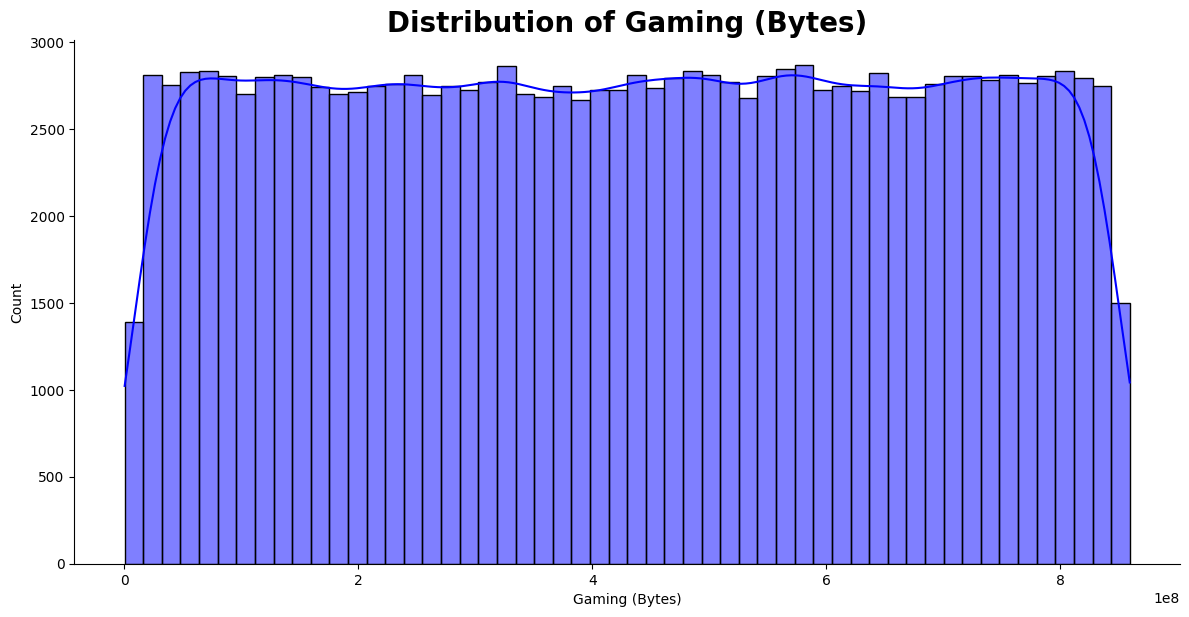

In [46]:
plot_hist(df, 'Gaming (Bytes)', 'blue')

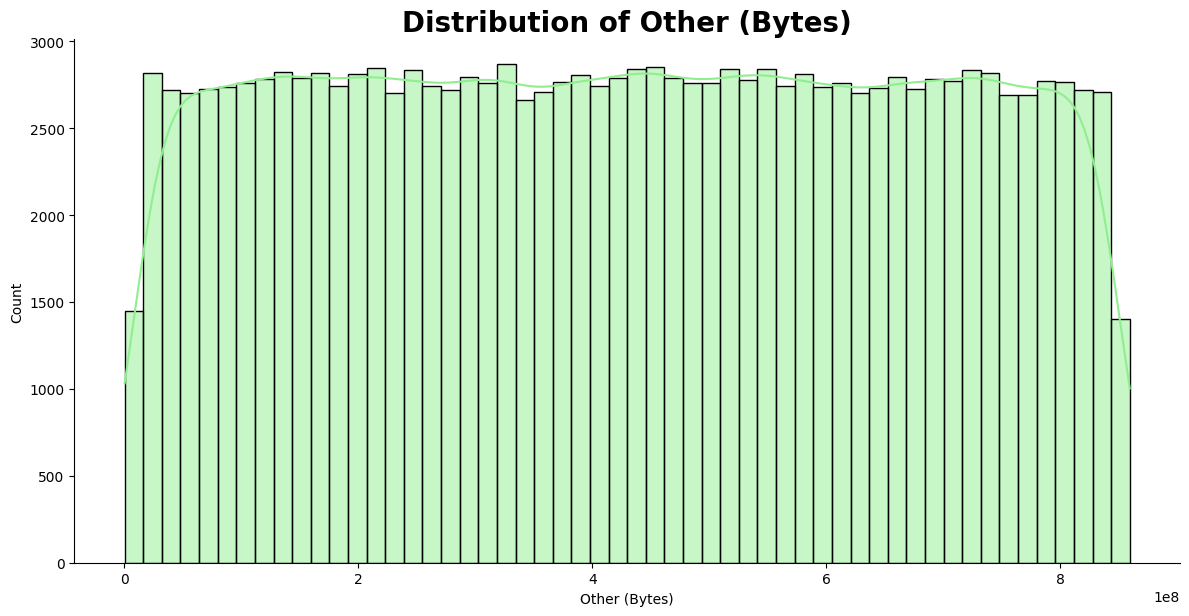

In [47]:
plot_hist(df, 'Other (Bytes)', 'lightgreen')

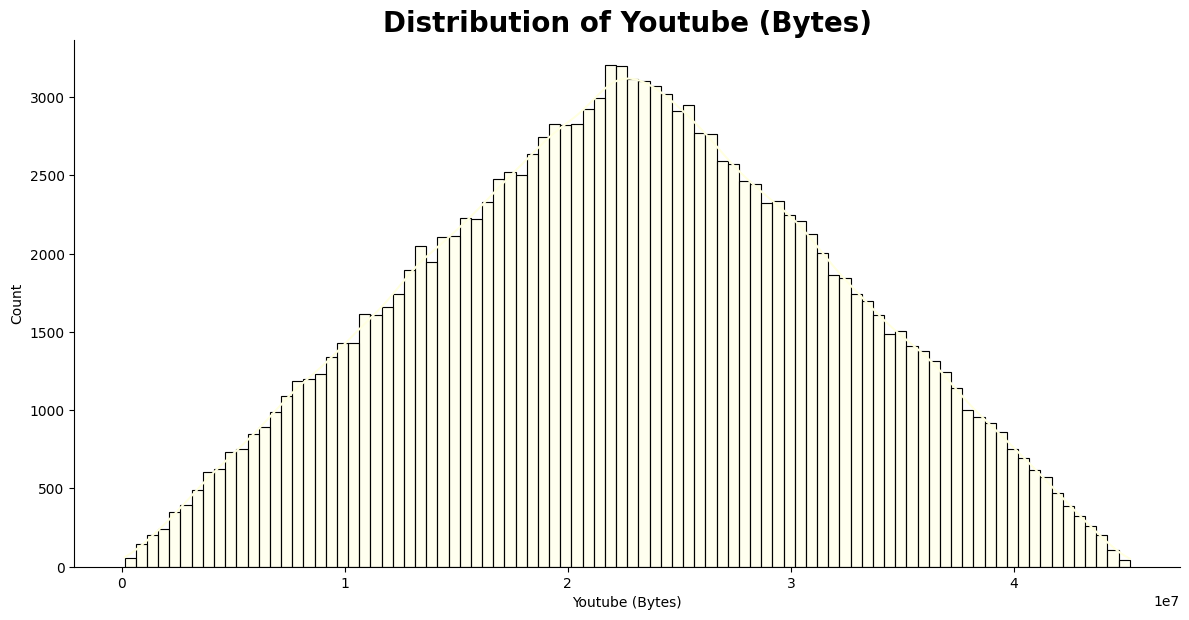

In [48]:
plot_hist(df, 'Youtube (Bytes)', 'lightyellow')